Heritability with Spatial Correction
=====

#####Version 0.2.17
Microsoft Research, September 4, 2015

### Packages Needed

Run this only if needed.

In [ ]:
#Main package
!pip install --upgrade fastlmm

#Needed by this notebook to generate synthetic SNPs
!pip install --upgrade GWAS_benchmark

###Notebook preparation and general use

To prepare this notebook to run analyses, please run the following script.  

In [1]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output or debug for info more)
import logging
logging.basicConfig(level=logging.DEBUG) #!!!cmk

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

## G_kernel

The program takes as input a kernel that reflects the genetic similarity between all pairs of individuals. This kernel can be given explicitly, for example a with a KernelData instance. The kernel can also be given implicitly by providing a set of SNPs, for example, via a BED file. In this case, we will generate synthetic SNPs.

In practice, we recommend using an IBD matrix to avoid biases in heritiability estimation. Here we generate synthetic data and use a kernel based on all these SNPs.

We generate data for 750 individuals and 750 SNPs from a Balding-Nichols model. Everyone will belong to one of two populations which will differ from each other by a fst of .1

In [2]:
from GWAS_benchmark.snp_gen import snp_gen
seed = 0
snpdata = snp_gen(fst=.1, dfr=0, iid_count=750, sid_count=750, chr_count=10, label_with_pop=True,seed=seed)
print snpdata.iid[:5] #The first 375 individals have fam_id of '0'
print snpdata.iid[750//2:][:5] #The second 375 individals have fam_id of '1'

[['0' '0']
 ['0' '1']
 ['0' '2']
 ['0' '3']
 ['0' '4']]
[['1' '0']
 ['1' '1']
 ['1' '2']
 ['1' '3']
 ['1' '4']]


C:\Anaconda\lib\site-packages\matplotlib\__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Although, not necessary, we can make the genetic similarity kernel explicit and plot it. The plots shows that everyone is completely similar to themselves, somewhat similar to people in the same population, and dissimilarity to people in the other population.

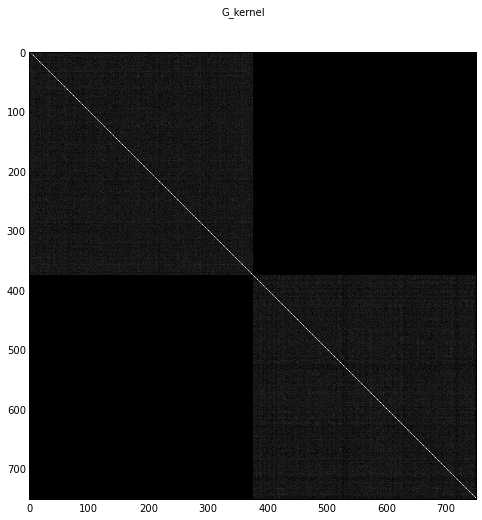

In [3]:
import pylab
from pysnptools.standardizer import Unit

G_kernel = snpdata.read_kernel(Unit()).standardize()
pylab.suptitle("G_kernel")
pylab.imshow(G_kernel.val, cmap=pylab.gray(), vmin=0, vmax=1)
pylab.show()

## Spatial Coordinates

The program also takes as input spatial coordinates for each individual. Here we'll randomly assign a location to each individual centered on one of two towns. The town for population 0 will be in the upper left and the town for population 1 will be in the lower right.

The plot shows the position of each individual. Reds (population 0) cluster around town 0 and blues (population 1) cluster around town 1.

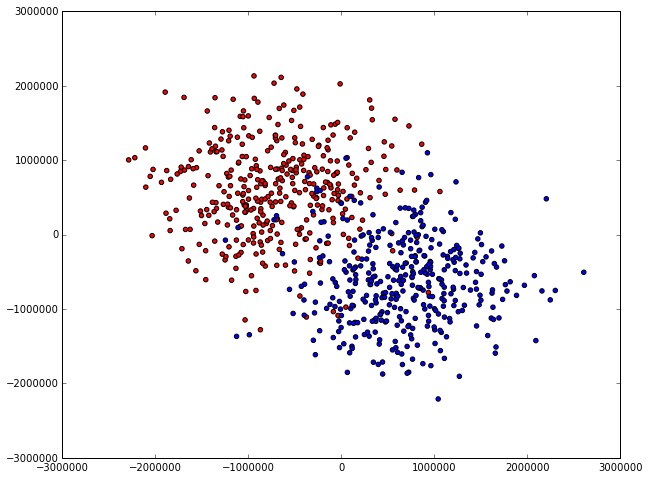

In [4]:
import numpy as np
seed = 0
np.random.seed(seed)
center_dict = {"0": (-1,1), "1": (1,-1)}
spatial_iid = snpdata.iid
centers = np.array([center_dict[iid_item[0]] for iid_item in spatial_iid])
dist_sd =  625000.
spatial_coor = (centers+np.random.multivariate_normal([0,0],[[1,0],[0,1]],size=snpdata.iid_count)) * dist_sd

import matplotlib.pyplot as plt
color_dict = {"0": "r", "1": "b", "2": "g"}
colors = [color_dict[iid_item] for iid_item in snpdata.iid[:,0]]
plt.scatter(spatial_coor[:,0], spatial_coor[:,1], c=colors)
plt.show()

In general, spatial_coor is the position of each individual given by two coordinates. Any units are allowed, but the two values must be compatible so that distance can be determined via Pythagoras' theorem. (So, longitude and latitude should not be used without correction unless the locations are near the Equator.)

## alpha_list

The program takes as input numbers to search to find the best alpha, which is the geo-spatial range of the environmental effect. Here the similarity of two individuals is defined as exp(-distance_between/alpha). If the closest individuals are 100 units apart and the farthest individuals are 4e6 units apart, a reasonable alpha_list might be:

In [5]:
alpha_list = [int(v) for v in np.logspace(np.log10(100),np.log10(1e10), 100)]
print alpha_list

[100, 120, 145, 174, 210, 253, 305, 367, 443, 533, 642, 774, 932, 1123, 1353, 1629, 1963, 2364, 2848, 3430, 4132, 4977, 5994, 7220, 8697, 10476, 12618, 15199, 18307, 22051, 26560, 31992, 38535, 46415, 55908, 67341, 81113, 97700, 117681, 141747, 170735, 205651, 247707, 298364, 359381, 432876, 521400, 628029, 756463, 911162, 1097498, 1321941, 1592282, 1917910, 2310129, 2782559, 3351602, 4037017, 4862601, 5857020, 7054802, 8497534, 10235310, 12328467, 14849682, 17886495, 21544346, 25950242, 31257158, 37649358, 45348785, 54622772, 65793322, 79248289, 95454845, 114975699, 138488637, 166810053, 200923300, 242012826, 291505306, 351119173, 422924287, 509413801, 613590727, 739072203, 890215085, 1072267222, 1291549665, 1555676143, 1873817422, 2257019719L, 2718588242L, 3274549162L, 3944206059L, 4750810162L, 5722367659L, 6892612104L, 8302175681L, 10000000000L]


Although, not necessary, we can make the spatial similarity kernel for a given alpha explicit and plot it.

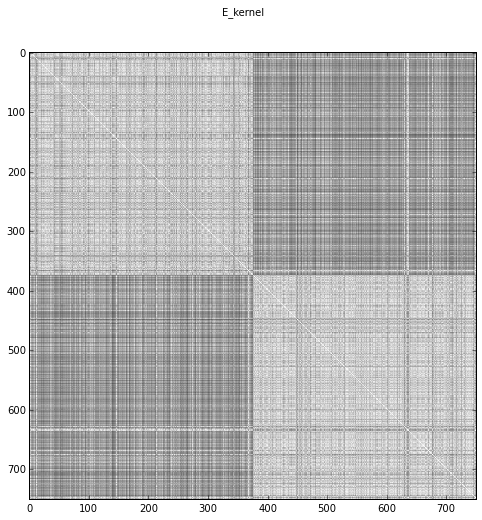

In [6]:
from fastlmm.association.heritability_spatial_correction import spatial_similarity
from pysnptools.kernelreader import KernelData

alpha = 4037017
spatial_val = spatial_similarity(spatial_coor, alpha)
E_kernel = KernelData(iid=snpdata.iid,val=spatial_val).standardize()
pylab.suptitle("E_kernel")
pylab.imshow(E_kernel.val, cmap=pylab.gray(), vmin=0, vmax=1)
pylab.show()

## Pheno

For this example, we'll generate one phenotype with 1 part pure noise and 0.25 parts "the distance to town 0".

The plot shows the phenotype for the 375 individuals of each population. The phenotype for population 0 (red) tend to be smaller because those individuals tend to be closer to town 0.

0.61701029616 1.42719510534


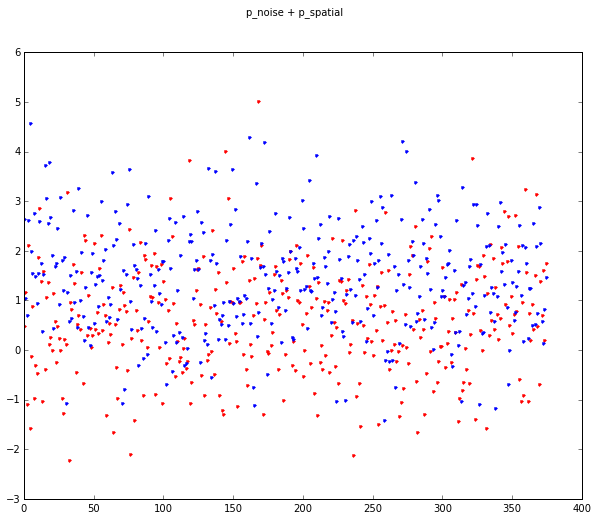

In [7]:
from pysnptools.snpreader import SnpData

seed = 2
np.random.seed(seed)
p_noise = np.random.normal(size=snpdata.iid_count)
p_spatial = np.sqrt(((spatial_coor - [-1*dist_sd,1*dist_sd])**2).sum(axis=1))/dist_sd #Distance to town 0
pheno_val = p_noise + .5*p_spatial
pheno = SnpData(iid=snpdata.iid,sid=["phen0"],val=pheno_val.reshape(-1,1))

is_pop0 = snpdata.iid[:,0]=="0"
is_pop1 = snpdata.iid[:,0]=="1"

print pheno_val[is_pop0].mean(),pheno_val[is_pop1].mean()

pylab.suptitle("p_noise + p_spatial")
plt.plot(range(sum(is_pop0)),pheno_val[is_pop0],"r.",range(sum(is_pop1)),pheno_val[is_pop1],"b.")
plt.show()

In general one or more phenotypes may be given either as PLINK pheno file or via any SnpReader.

## Running the Analysis

We're now ready to run the analysis, but the runs can take so long that we'll first do a test run with "just_testing=True". This skips over *all* LMM optimation (and thus all useful results). Each phenotype produces one row of results.

This *just_testing* run takes about 1 CPU minute.

In [8]:
from fastlmm.association import heritability_spatial_correction

dataframe = heritability_spatial_correction(
    snpdata,
    spatial_coor,spatial_iid,
    alpha_list=[4037017],pheno=pheno,
    jackknife_count=2,permute_plus_count=1,permute_times_count=1,just_testing=True)

dataframe

,phenotype,h2uncorr,SE (h2uncorr),h2corr,SE (h2corr),P (diff=0),e2,SE (e2),P(e2=0),alpha,alpha_gxe2,gxe2,SE (gxe2),P(gxe2=0)
0,phen0,0,0,0,0,NaN,0,0,1,4037017,4037017,0,0,0


Next, we'll do a real run, but we'll only look at one alpha and we'll set the jackknife and permutation counts very low. These counts are used to compute standard errors (SE) and P values, thus the SEs and P values produced by this run will not be real. Also, because only consider one alpha, we may not have found the best alpha values.

This "no meaningful SE or P values" run takes about 11 CPU minutes. (Running on a 20 processor machine and using the MKL library, the analysis takes about 30 seconds of clock time.)

In [10]:
dataframe = heritability_spatial_correction(
    snpdata,
    spatial_coor,spatial_iid,
    alpha_list=[4037017],pheno=pheno,
    jackknife_count=2,permute_plus_count=1,permute_times_count=1)

dataframe

,phenotype,h2uncorr,SE (h2uncorr),h2corr,SE (h2corr),P (diff=0),e2,SE (e2),P(e2=0),alpha,alpha_gxe2,gxe2,SE (gxe2),P(gxe2=0)
0,phen0,0.166111,0.065761,0.040682,0.019959,0.381662,0.376137,0.047414,0,4037017,4037017,0.008375,0.020689,0


Some points of interest:

  * h2uncorr is .17
  * h2corr is .04
  
So, it appears that correcting for spatial position is important on this data. (But we can't be sure without meaningful SE's and P values). Also

   * e2 = 0.38
   
which is similar to the 1:0.5 weight with which we generated the spatial effect.

#### Faster runs 
If you can define a function like Python's 'map' but that runs on a cluster, you make the run go much faster. Your custom map function just needs to run the function 'heritability_spatial_correction.work_item' on whatever arguments it is given.

Here is our map_function which runs work on an Windows HPC cluster.

In [9]:
from fastlmm.association.heritability_spatial_correction import work_item
from fastlmm.util import distributed_map
from fastlmm.util.runner import HPC

runner_function = lambda taskcount: HPC(min(taskcount,10100), 'GCR',r"\\GCR\Scratch\AZ-USCentral\escience",
                                        remote_python_parent=r"\\GCR\Scratch\AZ-USCentral\escience\carlk\data\carlk\pythonpath",
                                        unit='Core', #Core, Socket, Node
                                        update_remote_python_parent=True,
                                        template="Azure IaaS USCentral",
                                        mkl_num_threads=1
                                        )
fn_list = []
map_function = lambda ignore, arg_list, runner_function=runner_function, fn_list=fn_list : distributed_map.d_map(work_item, arg_list, runner_function(len(arg_list)), fn_list)


With the map_function above, we can search for the best alpha, jackknife to find standard errors, and permute to find P values. On a 80-node (640-core) [Azure HPC cluster](http://azure.microsoft.com/en-us/solutions/big-compute/), the run takes 40 minutes of clock time. The CPU time of the run is about 18 days.

Here is our call to run the full analysis on our cluster:

In [10]:
dataframe = heritability_spatial_correction(
    snpdata,
    spatial_coor,spatial_iid,
    alpha_list=alpha_list,pheno=pheno,
    map_function=map_function)
dataframe

,phenotype,h2uncorr,SE (h2uncorr),h2corr,SE (h2corr),P (diff=0),e2,SE (e2),P(e2=0),alpha,alpha_gxe2,gxe2,SE (gxe2),P(gxe2=0)
0,phen0,0.166111,0.046079,0.021796,0.026874,0.000003,0.672514,0.053287,0,14849682,12328467,0.001416,0.003092,0.3289


So the search of 100 alphas chooses 14,849,682 (and 12,328,467), instead of 4 million. This results in h2uncorr of .17 (SE=.05) and a h2corr of .02 (SE=.02). The two-sided P value of their difference is very, very small. e2 is now .67 (SE .05) and the P value that it differs from 0 is very, very low. The P value for "gxe2=0", on the other hand, says that the gxe kernel is not important.